## Generazione istanze

159.70284906663375

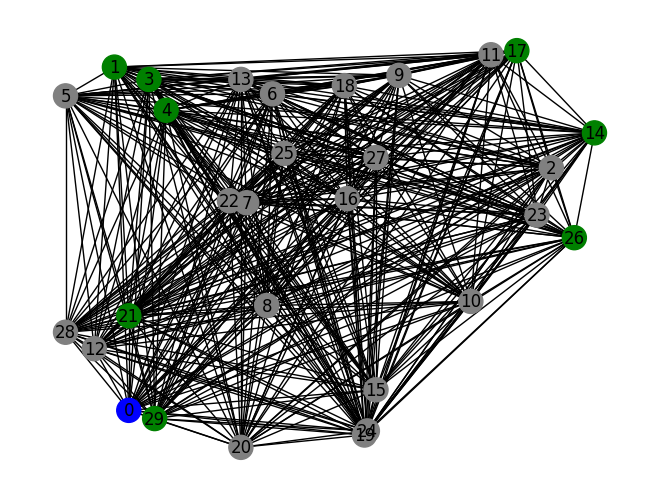

In [26]:
import networkx as nx 
import utility_function as uf

#generate a random graph
G=uf.random_euclidean_graph(30, 200)

#draw the graph with the type of node
uf.draw_graph(G)

#export in GML file
nx.write_gml(G, "istances/graph2.gml")
G[1][2]['weight']

## Euristica greedy e ad-hoc

Euristica Greedy per il problema GTSP. Alcune non sono greedy ma di ispirazione greedy.

### Nearest Neighbour (variante con autonomia)

A partire dal deposito di sceglie di spostarsi verso il cliente più vicino. Prima di farlo però si controlla che una volta raggiunto il nodo successivo sia possibile raggiungere la colonnina più vicina (altrimenti si resterebbe bloccati). Se non è possibile raggiungere la colonnina più vicina si sceglie la seconda più vicina e così via.

In alcuni potrebbe non riuscire a trovare una soluzione ammissibile e bloccarsi ritornando None.

Per evitare loop fra colonnine si tiene traccia di quelle già visitate e se si ritorna in una già vista si blocca l'algortimo ritornando None. Ogni volta che si visita un cliente si resetta la lista delle colonnine visitate.

È una variante dell'algoritmo Nearest Neighbour per il TSP.

In [3]:
import networkx as nx 
import utility_function as uf

def greedy_nearest_neighbour(G : nx.Graph, batteria_max : int):
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    nodo_attuale = 0
    batteria = batteria_max
    nodi_visitati = []
    nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volta
    soluzione = [0]
    collonnine_visitate = [] #per evitare cicli
    batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()

    soluzione_trovata = True

    for _ in range(2): #sserve imporre che l'ultimo nodo sia il deposito (quando ho visitato tutti i nodi aggiungo il deposito ai nodi da visitare)
        while len(nodi_da_visitare) > 0:
            #print(nodi_da_visitare)
            #get the nearest node (cliente)
            nodo_prossimo = uf.get_nearest_node(G, nodo_attuale, nodi_da_visitare)

            #check if the battery is enough to go to the nearest node and to reach the nearest charging station
            if batteria - nodo_prossimo[0] - uf.get_nearest_node(G, nodo_prossimo[1], collonnine)[0] < 0:
            
                #print("batteria insufficiente")

                #go to the nearest charging station
                nodo_prossimo = uf.get_nearest_node(G, nodo_attuale, collonnine) #la colonnina più vicina
                
                #se vero allora sono in loop e non posso raggiungere nessun cliente
                if(int(nodo_prossimo[1]) in collonnine_visitate):
                    #print("sono in una colonnina ma non ho abbastanza batteria per raggiungere un cliente")
                    soluzione_trovata = False
                    break

                collonnine_visitate.append(nodo_prossimo[1])

                #aggiornamento dello stato
                batteria = batteria_max
                nodi_visitati.append(nodo_attuale)
                nodo_attuale = nodo_prossimo[1]
                soluzione.append(nodo_attuale)
                batteria_per_nodo.append(batteria)
            else:
                #aggiornamento dello stato
                batteria -= nodo_prossimo[0]
                nodi_visitati.append(nodo_attuale)
                nodo_attuale = nodo_prossimo[1]
                nodi_da_visitare.remove(nodo_attuale)
                soluzione.append(nodo_attuale)
                batteria_per_nodo.append(batteria)

                collonnine_visitate=[]
            
            #print("nodo attuale: ", nodo_attuale, "batteria: ", batteria, "nodi da visitare: ", nodi_da_visitare, "soluzione: ", soluzione)
        
        #print("torno al deposito")
        nodi_da_visitare=[0]

    if soluzione_trovata != False:
        #soluzione.append(0)
        #print("soluzione: ", soluzione)
        return soluzione, batteria_per_nodo
    else:
        return None
    

soluzione trovata:
[0, 4, 10, 13, 3, 14, 11, 5, 12, 7, 12, 6, 2, 12, 3, 1, 3, 8, 9, 3, 0]
batteria_per_nodo:
[150, 144.34314575050763, 107.28913112320981, 65.42028829229318, 150, 111.7900536509144, 84.13142027903574, 57.11290810682314, 150, 88.77908853994413, 150, 65.27692168009946, 150, 150, 150, 82.93286945157114, 150, 72.79896373752487, 150, 150, 78.83118660536766]
costo:  1530


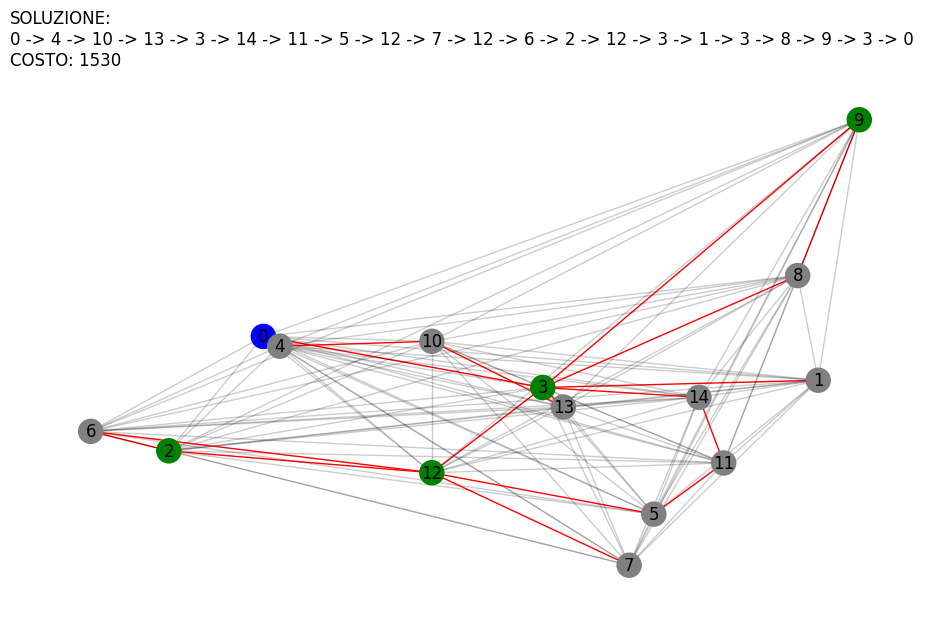

In [7]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_nearest_neighbour(G,batteria_max)

#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)




### Random insertion

In [4]:
import networkx as nx 
import utility_function as uf
import random

def greedy_random_insertion(G : nx.Graph, batteria_max : int):
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    nodo_attuale = 0
    batteria = batteria_max
    nodi_visitati = []
    nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volta
    batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()
    # inizio il tour dal deposito 
    tour = [nodo_attuale]
    #controllo se ci posso arrivare
    while len(nodi_da_visitare) > 0:

        
        random_node = get_random_node(G, nodi_da_visitare)

        #inserisco il nodo nella soluzione
        tour.append(random_node)
        nodi_da_visitare.remove(random_node)
        
    tour.append(0)
    batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,tour,batteria_max)
        
    return tour, batteria_per_nodo

def get_random_node(G : nx.Graph, nodi_da_visitare : list):
        return random.choice(nodi_da_visitare)

### Random insertion con colonnine

In [5]:
import networkx as nx 
import utility_function as uf
import random

def greedy_random_insertion_colonnine(G : nx.Graph, batteria_max : int):

    ammissibile = False
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    while ammissibile == False:
        colonnine_da_visitare = collonnine.copy()
        nodi_da_visitare = clienti.copy()  #devo anche tornare al deposito quindi lo devo visitare una seconda volta
        batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()
        # inizio il tour dal deposito 
        tour = [0]

        while len(nodi_da_visitare) > 0:
            
            random_node = random.choice(nodi_da_visitare + colonnine_da_visitare)
          

            #inserisco il nodo nella soluzione
            tour.append(random_node)
            try :
                nodi_da_visitare.remove(random_node)
            except ValueError:
               colonnine_da_visitare.remove(random_node)
            
            #print(tour)
            
        tour.append(0)
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,tour,batteria_max)

        ammissibile = not uf.check_batteria_negativa(batteria_per_nodo)
        #print(soluzione)
    return tour, batteria_per_nodo

In [28]:
import networkx as nx
import random
graph_file = "istances/graph.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]
random_node = random.choice(clienti +collonnine)

print(random_node)

for i in range(0, len(clienti)):
    print(random.choice(clienti +collonnine))

10
11
6
7
4
7
10
1
13
6
9


soluzione trovata:
[0, 10, 5, 11, 3, 13, 6, 2, 7, 8, 3, 4, 3, 1, 3, 14, 0]
batteria_per_nodo:
[250, 208.95124849645242, 119.74923058205768, 92.73071840984508, 250, 240.5660188679434, 125.13205506179145, 250, 128.53807180848807, 2.673064757282617, 250, 183.78066747542678, 250, 182.93286945157115, 250, 211.7900536509144, 102.88183541188525]
costo:  1757


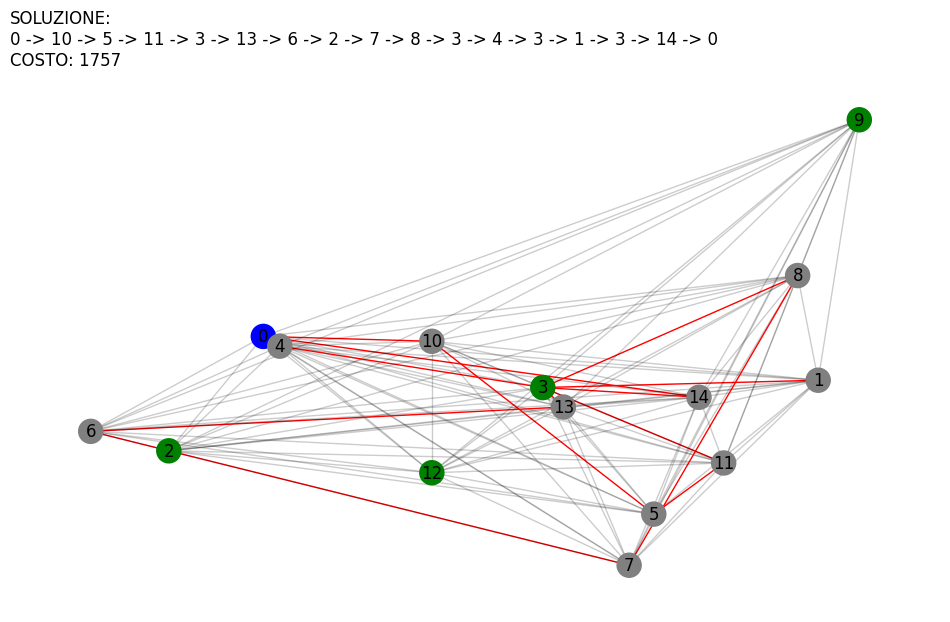

In [15]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza

graph_file = "istances/graph.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_random_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)


#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G,soluzione, batteria_per_nodo)
   
    #costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)

soluzione trovata:
[0, 14, 1, 3, 5, 7, 11, 12, 10, 6, 9, 8, 13, 2, 4, 0]
batteria_per_nodo:
[150, 41.09178176097086, 11.258913980618264, 150, 91.40819169883899, 69.56786203099743, 21.682582455745916, 150, 96.0, 5.12646149730935, 150, 84.26568628182082, 5.748172312006417, 150, 99.22599090085558, 93.5691366513632]
costo:  1631


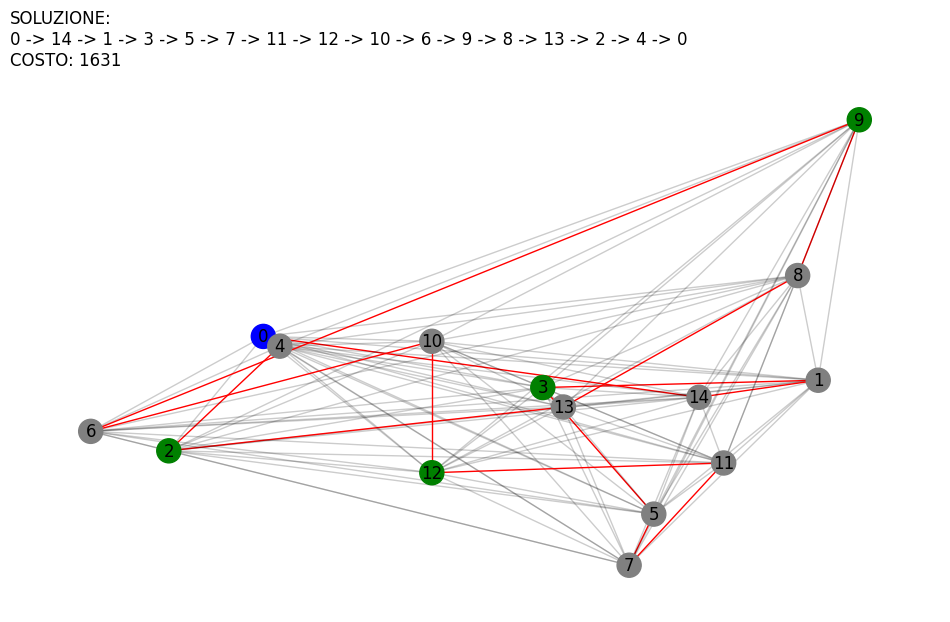

In [19]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_random_insertion_colonnine(G,batteria_max)

#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)


### Cheapest Insertion 
1. Parto sempre dal deposito e un cliente con l'arco più corto, ovvero quello che minimizza d(i, j) con i = 0 e j un cliente. **CONTROLLO:** devo poter raggiungere una colonnina arrivata a j.
2. Trovo il cliente il cui inserimento nel tour causa il minore aumento di lunghezza, ovvero il cliente k che minimizza d(i, k) + d(k, j) - d(i, j) con (i, j) un arco nel tour parziale. K potrebbe anche essere una colonnina.
3. Inserisco k tra i e j.
4. Ripeto fino a che non ho inserito tutti i clienti.    
5. Devo terminare in D.


In [7]:
import networkx as nx
import utility_function as uf

def greedy_cheapest_insertion(G : nx.Graph, batteria_max : int):
        #inizializzazione liste dal grafo di partenza
        clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
        collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

        nodo_attuale = 0
        nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volt  
        batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()

        soluzione_trovata = True

        #inizializzazione soluzione
        
        # inizio il tour dal deposito 
        tour = [nodo_attuale]
        #print(nodi_da_visitare)
        # trovo il nodo più vicino al deposito
        first_best = uf.get_nearest_node(G, nodo_attuale, nodi_da_visitare)
        # aggiungo il nodo alla soluzione
        #first_best è una tupla (dist, nodo)
        tour.append(first_best[1])
        tour.append(0)
        nodi_da_visitare.remove(first_best[1])
                
        while len(nodi_da_visitare) > 0:
                
                best_inserzione = (int(1000000000),0)
                # funzione che per ogni coppia di nodi in tour trova il nodo più vicino e lo inserisce
                for i in range(len(tour)-1):
                        
                        #prendo a due a due i nodi in tour 
                        nodo_attuale = tour[i]
                        nodo_successivo = tour[i+1]

                        #trovo il nodo più vicino a nodo_attuale e nodo_successivo
                        inserzione = uf.cheapest_deviation(G, nodo_attuale, nodo_successivo, nodi_da_visitare)
                        #coppia costo totale deviazione e nodo da cui passare
                        
                        if inserzione[0] < best_inserzione[0]:
                                best_inserzione = inserzione
                                best_inserzione_index = i+1
                                

                #inserisco il nodo nella soluzione
                tour.insert(best_inserzione_index,best_inserzione[1])
                nodi_da_visitare.remove(best_inserzione[1])
                #print(tour)

        for j in range(1,len(tour)):
                batteria =batteria_per_nodo[j-1]- G[tour[j-1]][tour[j]]['weight'] 
                batteria_per_nodo.append(batteria)

        return tour, batteria_per_nodo   





soluzione trovata:
[0, 23, 26, 9, 26, 15, 26, 16, 26, 10, 24, 22, 4, 27, 20, 29, 12, 29, 19, 18, 4, 13, 3, 5, 4, 8, 6, 21, 28, 2, 14, 25, 17, 11, 7, 0]
batteria_per_nodo:
[250, 79.15211444094487, 250, 150.19018084376668, 250, 148.82193913698484, 250, 168.7473077369125, 250, 202.49210591912117, 129.93178618443423, 8.079416490611692, 250, 173.4624275273902, 24.83537749947635, 250, 210.03751759462384, 250, 176.56295212905138, 6.4188955181899985, 250, 219.98333796039273, 250, 219.91678208701734, 250, 148.75771634341706, 45.73830069762727, 250, 226.59060017856075, 39.61199177642294, 250, 141.53802509635, 250, 240.7804555427071, 129.38476442316693, 20.380177363722495]
costo:  4592


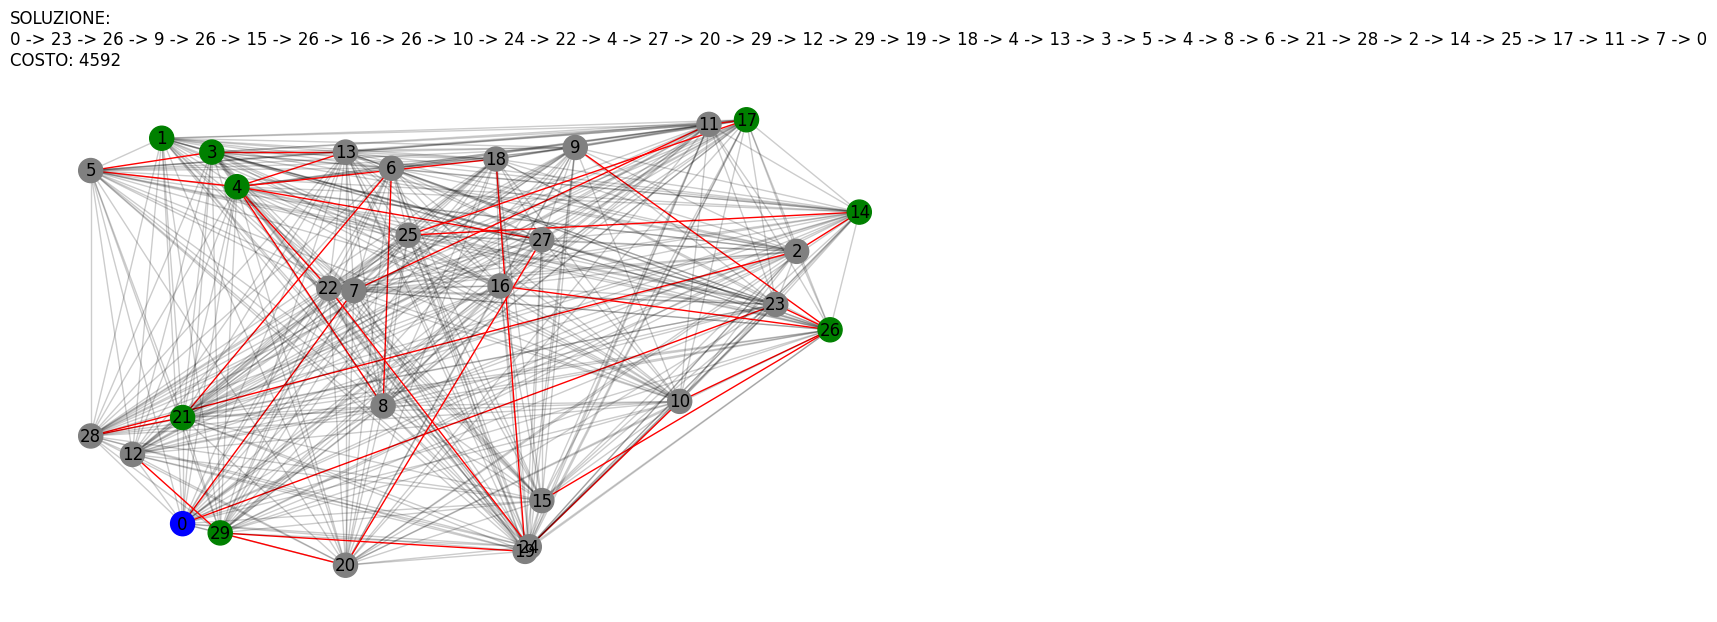

In [28]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza

graph_file = "istances/graph2.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_random_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)


#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G,soluzione, batteria_per_nodo)
   
    #costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)

In [52]:
import networkx as nx
import utility_function as uf

#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)
        
        
        

### Farthest Insertion
Questa euristica inizia con un percorso contenente un solo punto. In ogni passo, trova il punto non ancora incluso nel percorso che è il più lontano da ogni punto esistente nel percorso e richiede il minor costo per essere inserito. Questo processo viene ripetuto fino a quando tutti i punti non sono stati inseriti.

In [6]:
import networkx as nx 
import utility_function as uf

def greedy_farthest_insertion(G : nx.Graph, batteria_max : int):
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    nodo_attuale = 0
    batteria = batteria_max
    nodi_visitati = []
    nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volta
    soluzione = [0]
    colonnine_visitate = [] #per evitare cicli
    batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()

    tour = []
    soluzione_trovata = True
    farthest_node = (0,0)
    
    #inizializzazione soluzione
        
        # inizio il tour dal deposito 
    tour = [nodo_attuale]
    #print(nodi_da_visitare)
    # trovo il nodo più vicino al deposito
    first_best = uf.get_farthest_node(G, nodo_attuale, nodi_da_visitare)
    # aggiungo il nodo alla soluzione
    #first_best è una tupla (dist, nodo)
    tour.append(first_best[1])
    tour.append(0)
    nodi_da_visitare.remove(first_best[1])

    
    
     #controllo se ci posso arrivare
    while len(nodi_da_visitare) > 0:

        #print("nodi da visitare:", nodi_da_visitare)
        farthest_node = (int(0),0)
        
        #prendo il nodo più lontano dal tour 
        for i in tour:
            far_node = uf.get_farthest_node(G, i, nodi_da_visitare)
            #print("farnode", far_node)
            if far_node[0] > farthest_node[0]:
                farthest_node = far_node

        #print("nodo farthest:",farthest_node[1])
        best_inserzione = (int(100000000),0)
        for i in range(len(tour)-1):
                        
            #prendo a due a due i nodi in tour 
            nodo_attuale = tour[i]
            nodo_successivo = tour[i+1]

            #costo deviazione da i a nodo nuovo piu da nodo nuovo a i+1
            inserzione = G[nodo_attuale][int(farthest_node[1])]['weight'] + G[int(farthest_node[1])][nodo_successivo]['weight']
            #coppia costo totale deviazione e nodo da cui passare
            
            if inserzione < best_inserzione[0]:
                    best_inserzione = ( inserzione, farthest_node[1])
                    best_inserzione_index = i+1
                                

        #inserisco il nodo nella soluzione
        tour.insert(best_inserzione_index,best_inserzione[1])
        nodi_da_visitare.remove(best_inserzione[1])
        
       # print("Inserito:",farthest_node[1])
       # print("tour:", tour)

        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,tour,batteria_max)
                            
        #check if the battery is enough to go to the farthest node and to reach the farthest charging station
        if batteria_per_nodo[best_inserzione_index] - uf.get_nearest_node(G, farthest_node[1], collonnine)[0] < 0:
    
           # print("serve una colonnina prima di: " , tour[best_inserzione_index])

            #go to the nearest charging station
            nodo_colonnina = uf.cheapest_deviation(G, tour[best_inserzione_index-1], tour[best_inserzione_index], collonnine) #la colonnina più vicina
         

            #aggiornamento dello stato
            tour.insert(best_inserzione_index,nodo_colonnina[1])
            #print("aggiunta colonnina.", nodo_colonnina[1], "Tour:", tour)
        
        #nodi_visitati.append(farthest_node[1])
        #nodo_attuale = nodo_colonnina[1]
       

    return tour, batteria_per_nodo
    


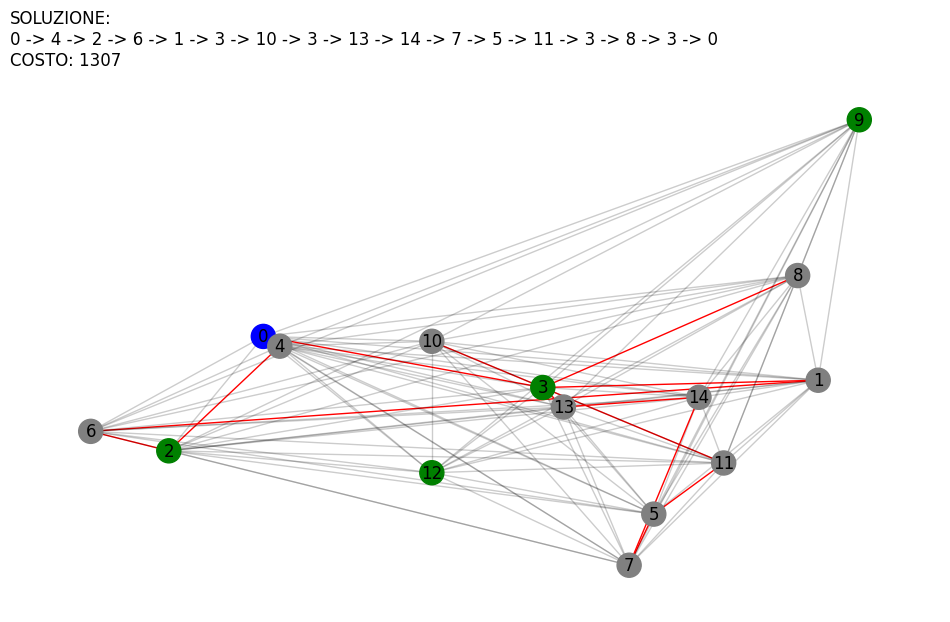

In [2]:


#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf


#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 200

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_farthest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo = uf.costo(G,soluzione, batteria_per_nodo)

#costo = uf.costo(G, soluzione, batteria_per_nodo)
#print("costo: ", costo)

#plot the solution
uf.draw_solution(G, soluzione , costo)

## Local search

Data una soluzione ottenuta da algoritmo greedy, si cerca di migliorarla usando la ricerca locale.

### City Swap

Data la soluzione nello forma di vettore di nodi visitati (in ordine) l'intorno è dato da tutte le soluzioni che si ottengono scambiando due nodi. Ci si ferma se non di in grado di determinare una soluzione migliore di quella attuale.

In [94]:
import networkx as nx
import utility_function as uf

def city_swap(G : nx.Graph, soluzione : list, batteria_per_nodo : list):
    
    batteria_max = batteria_per_nodo[0]

    soluzione_attuale = soluzione
    costo_attuale = uf.costo(G, soluzione_attuale, batteria_per_nodo)

    #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+1,len(soluzione)-1):
           
            #scambio i e j
            nuova_soluzione = soluzione_attuale.copy()
            nuova_soluzione[i], nuova_soluzione[j] = nuova_soluzione[j], nuova_soluzione[i]

            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)
            #print(nuova_soluzione)

            #controllo se la batteria è negativa (altrimenti soluzione non ammissibile)
            if uf.check_batteria_negativa(batteria_per_nodo) == True:
                #print("batteria negativa")
                nuova_soluzione, batteria_per_nodo= uf.add_colonnine_to_tour(G,nuova_soluzione,batteria_per_nodo,batteria_per_nodo[0])
                

            costo_nuova_soluzione = uf.costo(G, nuova_soluzione, batteria_per_nodo)
            #print("swap",i,j,costo_nuova_soluzione)
            #se il costo è minore allora aggiorno la soluzione
            if costo_nuova_soluzione < costo_attuale:
                print("soluzione migliore trovata, con costo: ", costo_nuova_soluzione)
                soluzione_attuale = nuova_soluzione
                costo_attuale = costo_nuova_soluzione

                return soluzione_attuale, batteria_per_nodo
    
    batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,soluzione_attuale,batteria_max)
    return soluzione_attuale, batteria_per_nodo
    

def local_city_swap(G : nx.Graph, soluzione : list, batteria_per_nodo : list):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        soluzione_nuova, batteria_per_nodo_nuova = city_swap(G, soluzione_attuale, batteria_per_nodo)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

   
    return soluzione_nuova, batteria_per_nodo_nuova

COSTO VECCCHIO:  1186
Improvement trovato 1154
Improvement trovato 1145
Improvement trovato 1098
Improvement trovato 1078
Improvement trovato 1070
Improvement trovato 1037
Improvement trovato 971
Improvement trovato 962
Improvement trovato 930
Improvement trovato 927
Improvement trovato 905
soluzione trovata:
[0, 10, 3, 14, 1, 8, 3, 11, 5, 7, 3, 13, 12, 2, 6, 4, 0]
batteria_per_nodo:
[150, 108.95124849645242, 150, 111.7900536509144, 81.9571858705618, 38.66746422673508, 150, 96.17621343680844, 69.15770126459584, 47.317371596754285, 150, 140.5660188679434, 150, 150, 129.3844718719117, 71.583087805438, 65.92623355594561]
COSTO NUOVO:  905


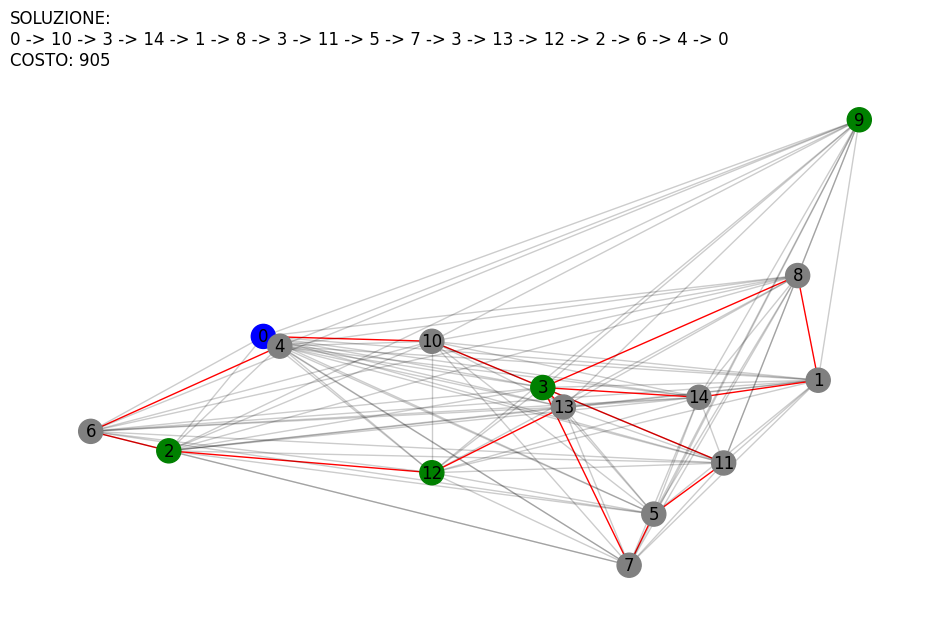

In [40]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE E DI QUELLA CON LA GREEDY VOLUTA
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)

#ricerca locale
soluzione, batteria_per_nodo = local_city_insertion(G, soluzione, batteria_per_nodo)


#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    batteria_per_nodo= uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G,soluzione, batteria_per_nodo)
    print("COSTO NUOVO: ", costo)
   
    #costo = uf.costo(G, soluzione, batteria_per_nodo)
    #print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)

### 2-opt

In [87]:
def two_2opt_swap(path, i, k):
  
    new_path = path[:i] + path[i:k+1][::-1] + path[k+1:]
   
    return new_path

def opt_swap_intorno(G, soluzione, batteria_per_nodo):
    batteria_max = batteria_per_nodo[0]

    soluzione_attuale = soluzione.copy()
    costo_attuale = uf.costo(G, soluzione_attuale, batteria_per_nodo)

    #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+2,len(soluzione)-1):

    
            #scambio i e j
            #nuova_soluzione = soluzione_attuale.copy()
            nuova_soluzione = two_2opt_swap(soluzione_attuale, i, j)

            #print(nuova_soluzione)
           
            batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)

            #controllo se la batteria è negativa (altrimenti soluzione non ammissibile)
            if uf.check_batteria_negativa(batteria_per_nodo_nuova) == True:
                #print("batteria negativa")
                nuova_soluzione, batteria_per_nodo_nuova = uf.add_colonnine_to_tour(G,nuova_soluzione,batteria_per_nodo_nuova,batteria_per_nodo[0])
                
           
            costo_nuova_soluzione = uf.costo(G, nuova_soluzione, batteria_per_nodo_nuova)
           
            #se il costo è minore allora aggiorno la soluzione
            if costo_nuova_soluzione < costo_attuale:
                #print("soluzione migliore trovata, con costo: ", costo_nuova_soluzione, costo_attuale)
                soluzione_attuale = nuova_soluzione
                costo_attuale = costo_nuova_soluzione

                batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)

                return soluzione_attuale, batteria_per_nodo_nuova
    
    
    batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,soluzione_attuale,batteria_max)
    return soluzione_attuale, batteria_per_nodo


def local_2opt_swap(G, soluzione, batteria_per_nodo):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        soluzione_nuova, batteria_per_nodo_nuova = opt_swap_intorno(G, soluzione_attuale, batteria_per_nodo_attuale)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    return soluzione_nuova, batteria_per_nodo_nuova

### City insertion

In [36]:
import networkx as nx
import numpy as np
def city_insertion_best_improvement(G : nx.Graph, soluzione : list, batteria_per_nodo : list):

    soluzione_best = soluzione
    batteria_per_nodo_best = batteria_per_nodo
    costo_best = uf.costo(G,soluzione,batteria_per_nodo)

       #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+1,len(soluzione)-1):

            soluzione_temp = soluzione.copy()

            #rimuovo il nodo i-esimo
            soluzione_temp.remove(soluzione[i])
            #lo riposizioni in posizione j-esima
            soluzione_temp.insert(j,soluzione[i])

            #calcolo il costo della nuova soluzione
            batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G,soluzione_temp,batteria_per_nodo[0])
            costo_temp = uf.costo(G,soluzione_temp,batteria_per_nodo_temp)

            if uf.check_batteria_negativa(batteria_per_nodo_temp) == False:
                if costo_temp < costo_best:
                    print("Improvement trovato", costo_temp)
                    #print(batteria_per_nodo_temp)
                    costo_best = costo_temp
                    soluzione_best = soluzione_temp
                    batteria_per_nodo_best = batteria_per_nodo_temp
   
    return soluzione_best, batteria_per_nodo_best


def local_city_insertion(G : nx.Graph, soluzione : list, batteria_per_nodo : list):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        soluzione_nuova, batteria_per_nodo_nuova = city_insertion_best_improvement(G, soluzione_attuale, batteria_per_nodo_attuale)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    return soluzione_nuova, batteria_per_nodo_nuova


### 3-opt

In [4]:
import itertools
import utility_function as uf


def intorno3opt(G,soluzione,batteria_per_nodo):
    #inizializzazione
    batteria_max = batteria_per_nodo[0]
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)


    allcombinantions = list(itertools.permutations(range(1, len(soluzione)-1),3))

    for lista_taglio in allcombinantions:
        sol_list = uf.generate_combination(soluzione, lista_taglio)

        best_in_list=100000000
        best_sol = None

        #cerchiamo in sol_list la soluzione migliore
        for i in sol_list:
            
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            costo = uf.costo(G,i, batteria_per_nodo)
            batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            if costo < best_in_list and uf.check_batteria_negativa(batteria_per_nodo_temp) == False:
                #print(i)
                best_in_list = costo
                best_sol = i
                batteria_per_nodo_list = batteria_per_nodo_temp

        #print("Best in list: ", best_in_list)
        
        if best_in_list < best_cost:
            #print("Trovata soluzione migliore", best_in_list)
            best_cost = best_in_list
            soluzione = best_sol
            batteria_per_nodo = batteria_per_nodo_list

        
    return soluzione, batteria_per_nodo

def local_3opt(G,soluzione,batteria_per_nodo):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        print("miglioro")
        soluzione_nuova, batteria_per_nodo_nuova = intorno3opt(G, soluzione_attuale, batteria_per_nodo_attuale)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    return soluzione_nuova, batteria_per_nodo_nuova
    
        

COSTO VECCCHIO:  4139
COSTO NUOVO:  1331
[250, 250, 250, 250, 250, 210.03751759462384, 197.23126911975814, 250, 250, 250, 201.7402859519454, 151.25266370648805, 145.16990117618982, 250, 250, 250, 250, 250, 250, 250, 214.3068634048505, 250, 218.0, 204.9615951895947, 175.6870328529858, 144.5743344807777, 122.21365470577982, 85.52578205009154, 65.87889934570303, 250, 240.7804555427071, 250, 250, 227.32843190249073, 250, 232.9706136340736, 250, 202.49210591912117, 148.28878498765056, 125.92810521265267, 123.69203723515288, 78.97067768515709, 36.01721449532803]
[0, 29, 29, 29, 29, 12, 28, 21, 21, 21, 8, 7, 22, 4, 4, 4, 4, 4, 4, 4, 5, 3, 13, 6, 25, 16, 27, 18, 9, 17, 11, 17, 14, 2, 26, 23, 26, 10, 15, 19, 24, 20, 0]


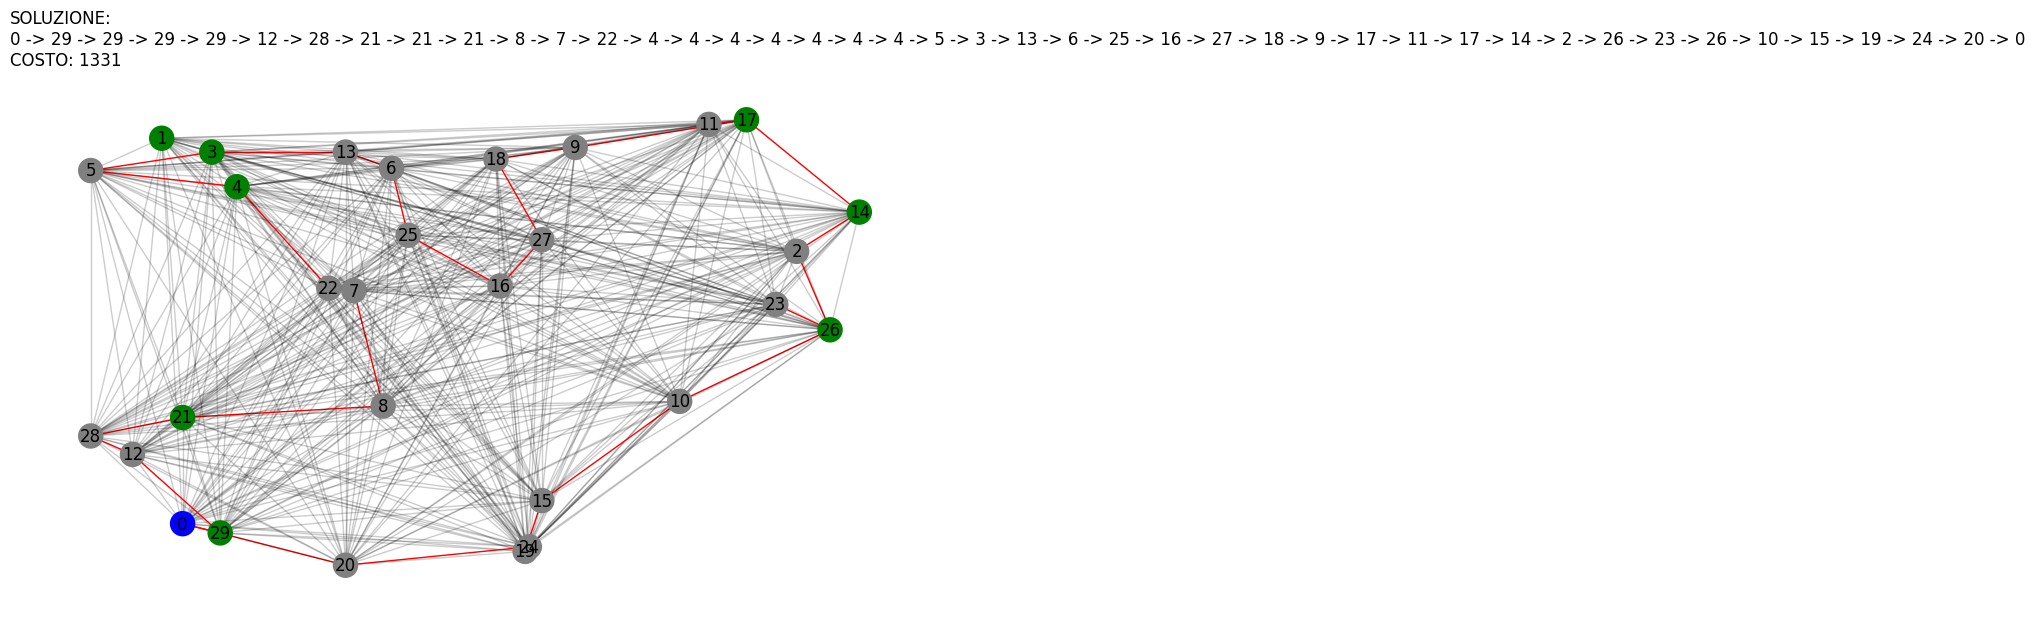

In [11]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/USA.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_random_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


soluzione, batteria_per_nodo = local_2opt_swap(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)



## Meta-euristiche

### Tabu search

Che come tutti sanno deriva dal Tongano lingua della polinesia e significa "che è proibito" o "che è tabù".

In [2]:
import itertools
import utility_function as uf


def tabu_intorno3opt(G,soluzione,batteria_per_nodo, tabu_list):
    #inizializzazione
    batteria_max = batteria_per_nodo[0]
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)


    allcombinantions = list(itertools.permutations(range(1, len(soluzione)-1),3))

    for lista_taglio in allcombinantions:
        sol_list = uf.generate_combination(soluzione, lista_taglio)

        best_in_list=100000000
        best_sol = None

        #cerchiamo in sol_list la soluzione migliore
        for i in sol_list:
            
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            costo = uf.costo(G,i, batteria_per_nodo)
            batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            if costo < best_in_list and uf.check_batteria_negativa(batteria_per_nodo_temp) == False and i not in tabu_list:
                #print(i)
                best_in_list = costo
                best_sol = i
                batteria_per_nodo_list = batteria_per_nodo_temp

        #print("Best in list: ", best_in_list)
        
        if best_in_list < best_cost:
            #print("Trovata soluzione migliore", best_in_list)
            best_cost = best_in_list
            soluzione = best_sol
            batteria_per_nodo = batteria_per_nodo_list

        
    return soluzione, batteria_per_nodo

def tabu_3opt(G,soluzione,batteria_per_nodo, tabu_list_len, max_iter):
    
    iter_no_improvement = 0
    tabu_list = [soluzione]

    best_soluzione = soluzione
    best_batteria_per_nodo = batteria_per_nodo
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)

    while iter_no_improvement < max_iter:
        print("Iterazione: ", iter_no_improvement)
        soluzione_nuova, batteria_per_nodo_nuova = tabu_intorno3opt(G, soluzione, batteria_per_nodo, tabu_list)
        
        costo_temp = uf.costo(G,soluzione_nuova, batteria_per_nodo_nuova)
        soluzione = soluzione_nuova
        batteria_per_nodo = batteria_per_nodo_nuova

        tabu_list.append(soluzione)

        if len(tabu_list) > tabu_list_len:
            tabu_list.pop(0)


        if costo_temp < best_cost:
            best_cost = costo_temp
            best_soluzione = soluzione
            best_batteria_per_nodo = batteria_per_nodo
            iter_no_improvement = 0
        else:
            soluzione = soluzione_nuova
            batteria_per_nodo = batteria_per_nodo_nuova
            iter_no_improvement += 1
            
       
    return best_soluzione, best_batteria_per_nodo
    

### Double bridge (ILS)


In [114]:
import networkx as nx
import utility_function as uf
import numpy as np

def mossa_doublebridge(soluzione : list):
    #scelgo 4 numeri a caso
    lista_tagli = []
    while len(lista_tagli) < 4:
        numero = np.random.randint(1,len(soluzione)-1)
        if numero not in lista_tagli:
            #print("appendo")
            lista_tagli.append(numero)

    lista_tagli.sort()

    print(lista_tagli)
    
    a = lista_tagli[0]
    b = lista_tagli[1]
    c = lista_tagli[2]
    d = lista_tagli[3]

    #mossa double bridge
    soluzione_nuova = soluzione[:a] + soluzione[c:d] + soluzione[b:c] + soluzione[a:b] + soluzione[d:]

    return soluzione_nuova



def doublebridge(G,soluzione,batteria_per_nodo,iterazioni):
    soluzione_best = soluzione.copy()
    costo_best = uf.costo(G,soluzione,batteria_per_nodo)
    batteria_max = batteria_per_nodo[0]

    nuova_soluzione = soluzione.copy()

    iterazioni_no_improvement = 0

    print("sol:", soluzione)

    while iterazioni_no_improvement < iterazioni:
  
        nuova_soluzione = mossa_doublebridge(nuova_soluzione)
        print("db:",nuova_soluzione)
        batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)


        nuova_soluzione, batteria_per_nodo_nuova = local_2opt_swap(G,nuova_soluzione,batteria_per_nodo_nuova)
        print("2opt:", nuova_soluzione)

        if uf.check_batteria_negativa(batteria_per_nodo_nuova) == True:
                #print("batteria negativa")
                nuova_soluzione, batteria_per_nodo_nuova = uf.add_colonnine_to_tour(G,nuova_soluzione,batteria_per_nodo_nuova,batteria_per_nodo[0])

        costo = uf.costo(G,nuova_soluzione,batteria_per_nodo_nuova)
        
        print("Costo: ", costo)

        if costo < costo_best:
            costo_best = costo
            soluzione_best = nuova_soluzione
            batteria_per_nodo_best = batteria_per_nodo_nuova
            iterazioni_no_improvement = 0
        
        
        iterazioni_no_improvement += 1

    return soluzione_best, batteria_per_nodo_best

def compact_list(lista):
    lista_compatta = []
    for i in lista:
        if i not in lista_compatta:
            lista_compatta.append(i)
    return lista_compatta


COSTO VECCCHIO:  1431
sol: [0, 4, 6, 3, 1, 3, 10, 13, 14, 3, 7, 12, 5, 11, 3, 8, 3, 0]
[1, 6, 7, 10]
db: [0, 13, 14, 3, 10, 4, 6, 3, 1, 3, 7, 12, 5, 11, 3, 8, 3, 0]
2opt: [0, 2, 6, 12, 7, 5, 3, 11, 1, 8, 3, 3, 3, 3, 3, 13, 14, 3, 10, 4, 0]
Costo:  955
[3, 7, 14, 15]
db: [0, 2, 6, 3, 11, 1, 8, 3, 3, 3, 3, 12, 7, 5, 3, 13, 14, 3, 10, 4, 0]
2opt: [0, 2, 6, 12, 7, 5, 3, 11, 1, 8, 3, 3, 3, 3, 3, 3, 13, 14, 3, 10, 4, 0]
Costo:  955
[3, 7, 14, 17]
db: [0, 2, 6, 3, 3, 13, 11, 1, 8, 3, 3, 3, 3, 12, 7, 5, 3, 14, 3, 10, 4, 0]
2opt: [0, 2, 6, 12, 7, 5, 3, 11, 1, 8, 3, 3, 3, 3, 3, 3, 3, 3, 13, 14, 3, 10, 4, 0]
Costo:  955
[7, 11, 12, 20]
db: [0, 2, 6, 12, 7, 5, 3, 3, 3, 3, 3, 3, 3, 13, 14, 3, 11, 1, 8, 3, 3, 10, 4, 0]
2opt: [0, 2, 6, 12, 7, 5, 11, 3, 3, 3, 3, 3, 3, 3, 3, 13, 3, 14, 1, 8, 3, 3, 10, 4, 0]
Costo:  856
[2, 10, 13, 19]
db: [0, 2, 3, 3, 13, 3, 14, 1, 3, 3, 3, 6, 12, 7, 5, 11, 3, 3, 3, 8, 3, 3, 10, 4, 0]
2opt: [0, 2, 6, 12, 7, 5, 3, 11, 1, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 13, 3, 3, 3, 14, 10

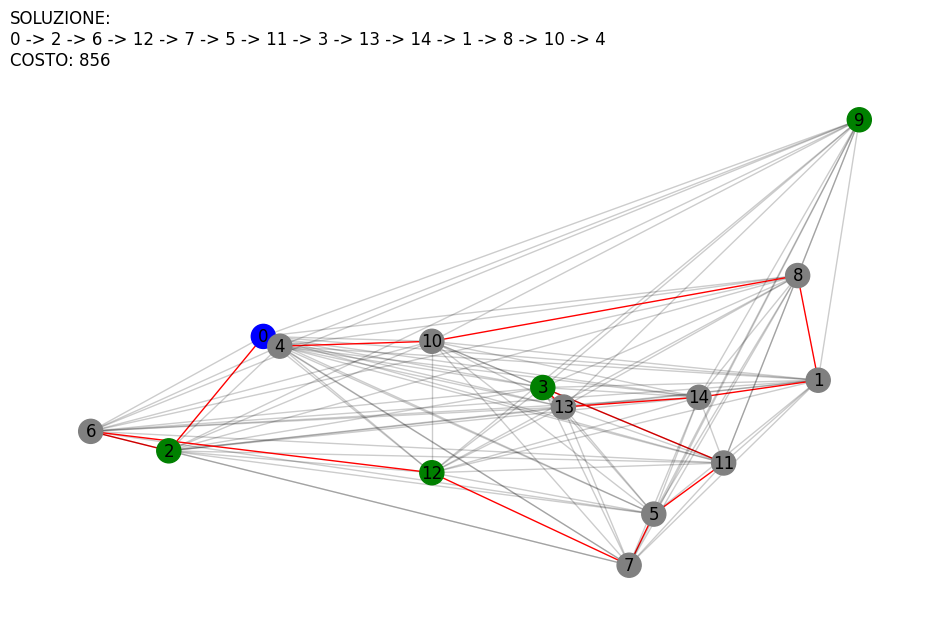

In [115]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_farthest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


#soluzione, batteria_per_nodo = tabu_3opt(G, soluzione, batteria_per_nodo,4,4)
soluzione, batteria_per_nodo = doublebridge(G, soluzione, batteria_per_nodo,50)
costo= uf.costo(G,soluzione, batteria_per_nodo)

soluzione = compact_list(soluzione)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

In [ ]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_random_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


soluzione, batteria_per_nodo = tabu_3opt(G, soluzione, batteria_per_nodo,2,20)
#soluzione, batteria_per_nodo = local_3opt(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

### Ant Colony


{'0': (24, 28), '2': (142, 175), '5': (177, 6), '6': (178, 78), '7': (125, 69), '8': (75, 76), '9': (187, 122), '10': (77, 147), '11': (197, 154), '12': (54, 16), '13': (185, 67), '15': (34, 114), '16': (127, 104), '18': (182, 103), '19': (12, 110), '20': (6, 67), '22': (126, 63), '23': (119, 170), '24': (14, 111), '25': (149, 82), '27': (147, 114), '28': (62, 6)}
22
{'path_cost': 1303, 'ants_used': 1, 'epoch': 1175, 'round_trips': 1, 'clock': 0}
{'path_cost': 1261, 'ants_used': 131, 'epoch': 2819, 'round_trips': 2, 'clock': 0}
{'path_cost': 1260, 'ants_used': 144, 'epoch': 2975, 'round_trips': 2, 'clock': 0}
{'path_cost': 1226, 'ants_used': 258, 'epoch': 4042, 'round_trips': 3, 'clock': 0}
{'path_cost': 1172, 'ants_used': 260, 'epoch': 4148, 'round_trips': 3, 'clock': 0}
{'path_cost': 1128, 'ants_used': 386, 'epoch': 5341, 'round_trips': 4, 'clock': 0}
{'path_cost': 1126, 'ants_used': 399, 'epoch': 5710, 'round_trips': 4, 'clock': 0}
{'path_cost': 1109, 'ants_used': 560, 'epoch': 7256

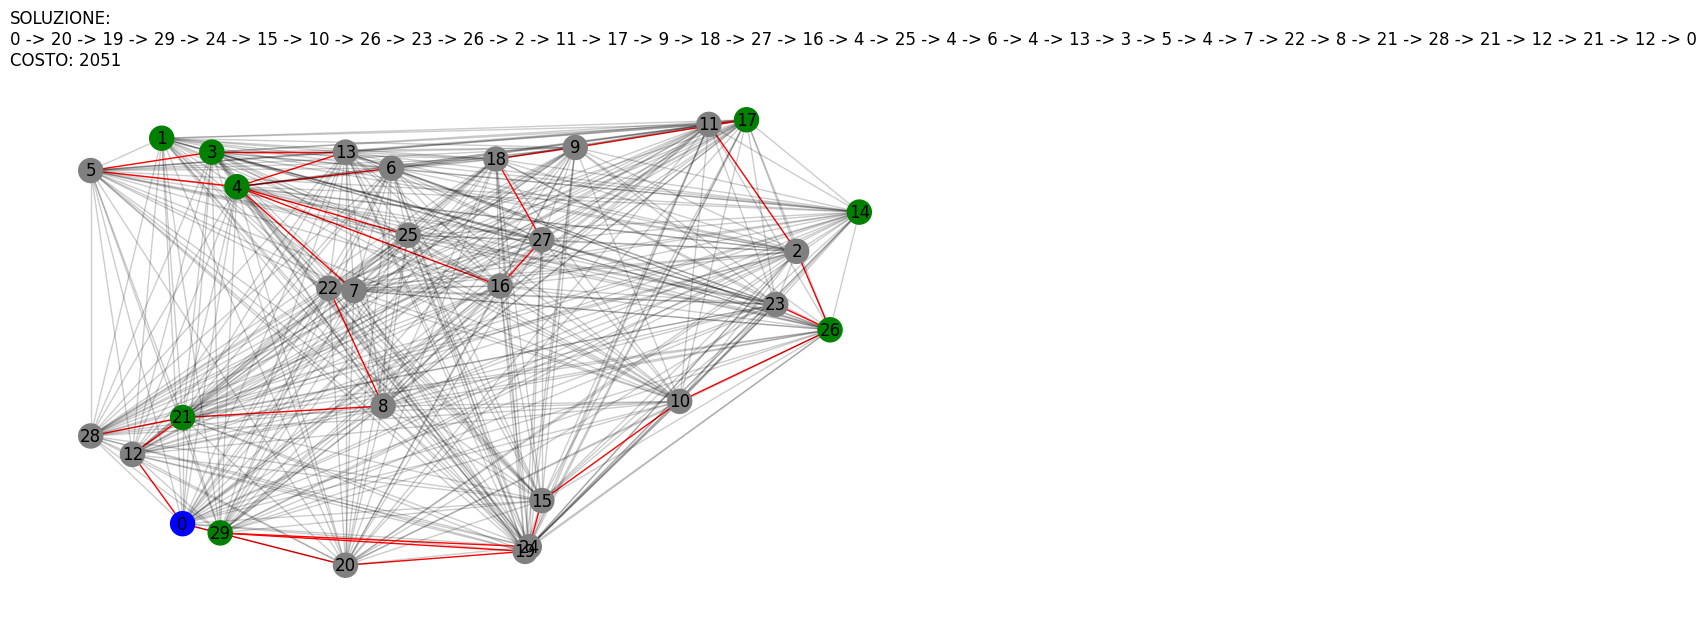

In [23]:
import ant_colony

graph_file = "istances/USA.gml"
batteria_max = 150

G = nx.read_gml(graph_file, destringizer=int)
#estraggo i clienti
clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente" or G.nodes[node]['type'] == "deposito"]

client_dict = {str(i): tuple(G.nodes[i]['pos']) for i in clienti}
for i in clienti:
    tupla = [ int(G.nodes[i]['pos'][1]), int(G.nodes[i]['pos'][0]) ]
    tupla = tuple(tupla)
    client_dict[str(i)] = tupla

print(client_dict)

clienti = list(sorted(client_dict.items()))
print(len(clienti))

results = ant_colony.AntColonyRunner(clienti, distance_power=1, verbose=True, plot=False)
#[('0', (97, 50)), ('4', (93, 54)), ('10', (95, 91)), ('13', (68, 123)), ('14', (72, 156)), ('8', (122, 180)), ('1', (79, 185)), ('11', (45, 162)), ('5', (24, 145)), ('7', (3, 139)), ('6', (58, 8)), ('6', (58, 8)), ('0', (97, 50))]
print(results)

#estraggo la soluzione
soluzione = []
for i in results:
    soluzione.append(int(i[0]))
print(soluzione)

batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione,batteria_per_nodo, batteria_max)

costo = uf.costo(G, soluzione, batteria_per_nodo)
print(soluzione)
print(batteria_per_nodo)
uf.draw_solution(G, soluzione, costo)

In [95]:
soluzione = []
for i in results:
    soluzione.append(int(i[0]))
print(soluzione)

[0, 4, 10, 13, 8, 1, 14, 11, 5, 7, 6, 6, 0]


### Simulated Annealing

In [17]:
import networkx as nx
import utility_function as uf
import random as rnd
import numpy as np

#simulated annealing per TSP

    

def simulated_annealing(G, soluzione:list, batteria_per_nodo:list, temp_max:int, alpha:int, batteria_max:int):
    temp = temp_max
    temp_min = 0.1
    soluzione_attuale = soluzione.copy()
    soluzione_best = soluzione.copy()
    costo_best = uf.costo(G, soluzione, batteria_per_nodo)
    fitness_list = []

    #creo nuova soluzione partendo da questa con city insertion
    while temp > temp_min:
        i= rnd.randint(1,len(soluzione)-2)
        j= rnd.randint(1,len(soluzione)-2)

        soluzione_temp=soluzione_attuale.copy()
        soluzione_temp[i], soluzione_temp[j] = soluzione_temp[j], soluzione_temp[i]

        batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G, soluzione_temp, batteria_max)
        if uf.check_batteria_negativa(batteria_per_nodo_temp) == False: #ammissibile
            costo = uf.costo(G,soluzione_temp,batteria_per_nodo_temp)
            if costo < costo_best: #meglio
                print("costo best: ", costo_best)
                soluzione_best = soluzione_temp
                costo_best = costo
                soluzione_attuale = soluzione_temp
                fitness_list.append(costo_best)
            else:
                delta = costo - costo_best
                if rnd.random() < np.exp(-delta/temp):
                    soluzione_attuale = soluzione_temp  
                    fitness_list.append(costo)
                else:
                    fitness_list.append(costo)
          

          
                


        temp = temp*alpha
    batteria_per_nodo_best = uf.calcolo_batteria_per_nodo(G, soluzione_best, batteria_max)
    return soluzione_best, batteria_per_nodo_best, fitness_list


COSTO VECCCHIO:  1431
costo best:  1431
costo best:  1384
costo best:  1359
costo best:  1254
costo best:  1155
costo best:  1149
costo best:  1127
costo best:  1115
costo best:  1090
costo best:  1050
costo best:  944
costo best:  920
costo best:  894
COSTO NUOVO:  887
[150, 144.34314575050763, 107.28913112320981, 150, 140.5660188679434, 95.28909317725632, 68.27058100504372, 46.430251337202165, 150, 150, 111.7900536509144, 81.9571858705618, 38.66746422673508, 150, 150, 150, 65.27692168009946, 7.9620021564710655]
[0, 4, 10, 3, 13, 11, 5, 7, 3, 3, 14, 1, 8, 3, 3, 12, 6, 0]


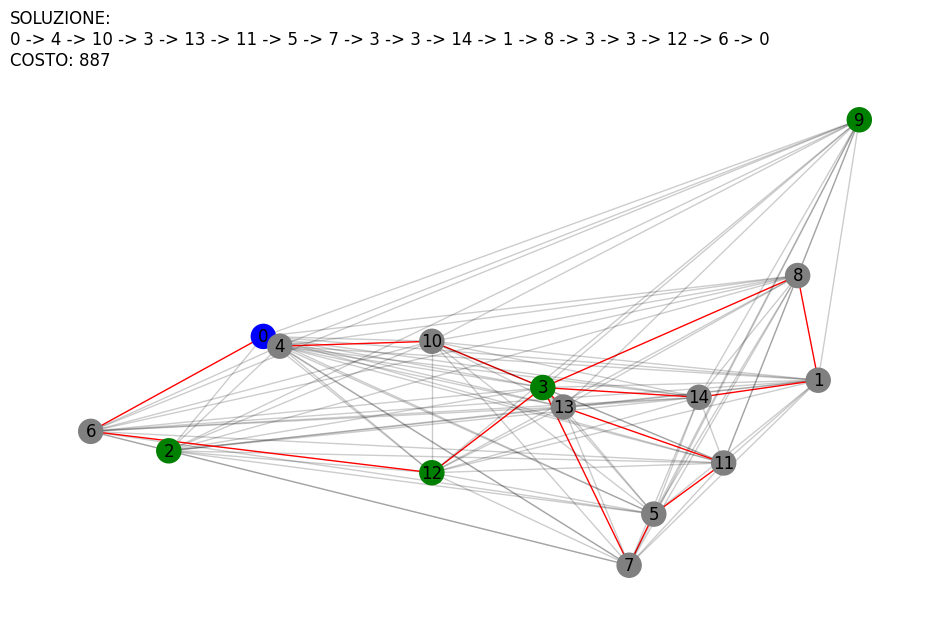

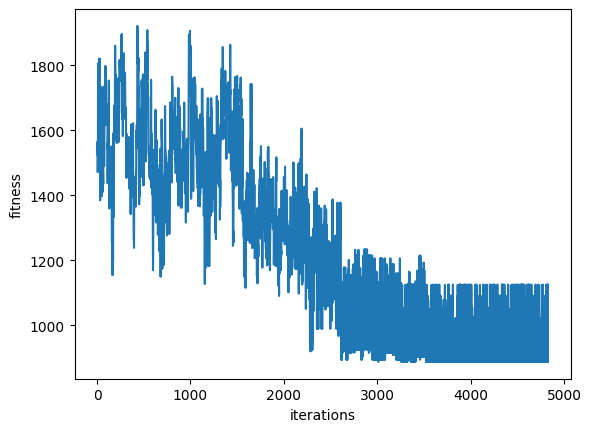

In [22]:
import itertools
import networkx as nx 
import utility_function as uf
import matplotlib.pyplot as plt

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_farthest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


soluzione, batteria_per_nodo, fitness_list = simulated_annealing(G, soluzione, batteria_per_nodo, 50000, 0.999, batteria_max)
#soluzione, batteria_per_nodo = local_3opt(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

#plot fitness_list over iterations
plt.plot(fitness_list)
plt.ylabel('fitness')
plt.xlabel('iterations')
plt.show()




## Algoritmi Genetici

### Swap crossover

In [27]:
import utility_function as uf
import random as rnd

def random_swap(sol):
    i= rnd.randint(1,len(sol)-2)
    j= rnd.randint(1,len(sol)-2)

    soluzione_temp=sol.copy()
    soluzione_temp[i], soluzione_temp[j] = soluzione_temp[j], soluzione_temp[i]

    return soluzione_temp

def generate_population_swap(G,parents_list, n_figli, batteria_max):
    children_list = []
    for i in parents_list:
        for j in range(n_figli):
            figlio = random_swap(i[0])
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, figlio, batteria_max)

            if uf.check_batteria_negativa(batteria_per_nodo) == False:
                costo = uf.costo(G, figlio, batteria_per_nodo)
                children_list.append( (figlio, costo))
               

    #aggiungo i parents alla lista
    for i in parents_list:
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i[0], batteria_max)
        if uf.check_batteria_negativa(batteria_per_nodo) == False:
            costo = uf.costo(G, i[0], batteria_per_nodo)    
            children_list.append( (i[0], costo))

    #elimino i figli non ammissibili


    #ordino la lista dei figli in base al costo
    children_list.sort(key=lambda x: x[1])
    
    return children_list

def ga_swap_crossover(G, sol_list : list, n_figli : int, n_figli_per_epoca : int, max_generation : int, batteria_max : int):
    for i in range(max_generation):
        #genero i figli
        children_list = generate_population_swap(G, sol_list, n_figli, batteria_max)

        #seleziono i migliori figli
        sol_list = children_list[:n_figli_per_epoca]

        #stampo il miglior figlio
        print("Best child: ", sol_list[0][1])
    
    soluzione_best = sol_list[0][0]
    batteria_per_nodo_best = uf.calcolo_batteria_per_nodo(G,soluzione_best,batteria_max)
    costo_best = sol_list[0][1]

    print("costo FINALE:", costo_best)


    return soluzione_best, batteria_per_nodo_best
    
    


### GA per TSP

Si fa ereditare al figlio, dal secondo genitore, solo la posizione relativa dei nodi e non quella assoluta. Dal primo genitore invece quella assoluta.



In [57]:

import utility_function as uf
import random as rnd

def crossover(padre: list, madre: list, idx_taglio : int):
    '''
    Genera una una soluzione crossover a partire da padre e madre. Dal padre eredita i primi idx_taglio elementi, dalla madre gli altri (in modo relativo)
    '''
    figlio = padre[:idx_taglio]
    for i in madre:
        if i not in figlio:
            figlio.append(i)
    figlio.append(0)
    return figlio

def generate_population_crossover(G,parents_list, batteria_max):
    children_list = []
    for i in itertools.permutations(parents_list,2):
        taglio = rnd.randint(2,len(i[0][0])-2)
       
        #primo figlio
       
        figlio = crossover(i[0][0],i[1][0], taglio)
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, figlio, batteria_max)

        if uf.check_batteria_negativa(batteria_per_nodo) == False:
            costo = uf.costo(G, figlio, batteria_per_nodo)
            print("Trovata ammissibile con costo:", costo)
            children_list.append( (figlio, costo))


        #aggiungo i parents alla lista
        for i in parents_list:
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i[0], batteria_max)
            if uf.check_batteria_negativa(batteria_per_nodo) == False:
                costo = uf.costo(G, i[0], batteria_per_nodo)    
                children_list.append( (i[0], costo))

        #ordino la lista dei figli in base al costo
        children_list.sort(key=lambda x: x[1])
        
    return children_list

def ga_crossover(G, sol_list, max_popolazione, max_generation, batteria_max):
    for i in range(max_generation):
        print("Generazione: ", i)
        #genero i figli
        children_list = generate_population_crossover(G, sol_list, batteria_max)

        #seleziono i migliori figli
        sol_list = children_list[:max_popolazione]

        #stampo il miglior figlio
        print("Best child: ", sol_list[0][1])
    
    soluzione_best = sol_list[0][0]
    batteria_per_nodo_best = uf.calcolo_batteria_per_nodo(G,soluzione_best,batteria_max)
    costo_best = sol_list[0][1]

    print("costo FINALE:", costo_best)


    return soluzione_best, batteria_per_nodo_best


1923 1805
Generazione:  0
Trovata ammissibile con costo: 2259
Best child:  1805
Generazione:  1
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1743
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1982
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1743
Trovata ammissibile con costo: 1743
Trovata ammissibile con costo: 1946
Trovata ammissibile con costo: 2260
Trovata ammissibile con costo: 2233
Trovata ammissibile con costo: 1825
Trovata ammissibile con costo: 2233
Trovata ammissibile con costo: 2259
Trovata ammissibile con costo: 2259
Trovata ammissibile con costo: 1987
Best child:  1743
Generazione:  2
Trovata ammissibile con costo: 1743
Trovata ammissibile con costo: 1743
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1805
Trovata ammissibile con costo: 1743
Trovata ammissibile con costo: 1805
Trovat

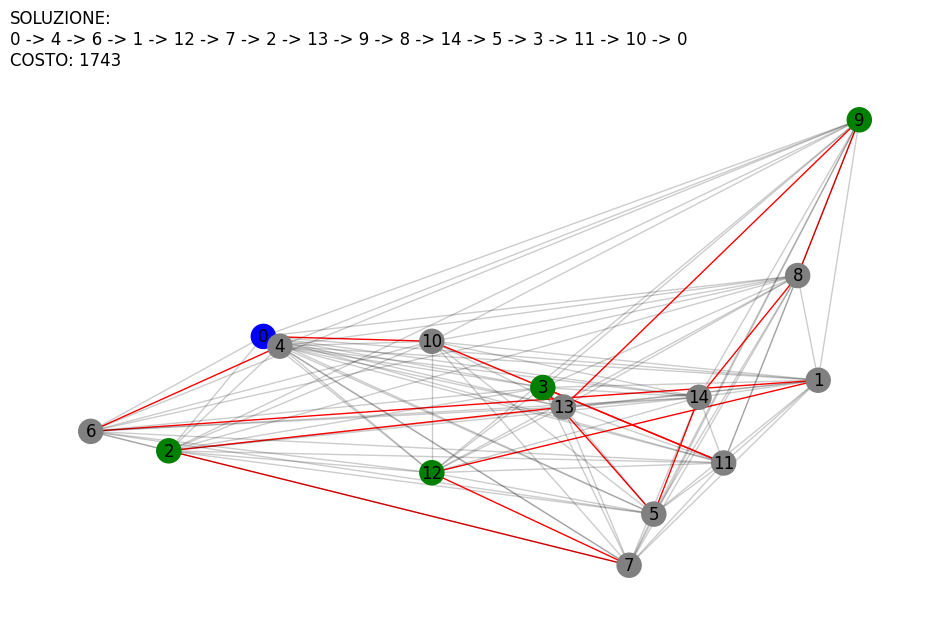

In [60]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione1, batteria_per_nodo = greedy_farthest_insertion(G,batteria_max)
soluzione1, batteria_per_nodo= uf.add_colonnine_to_tour(G, soluzione1, batteria_per_nodo, batteria_max)
costo1 = uf.costo(G,soluzione1,batteria_per_nodo)

soluzione2,  batteria_per_nodo= greedy_cheapest_insertion(G,batteria_max)
soluzione2, batteria_per_nodo= uf.add_colonnine_to_tour(G, soluzione2, batteria_per_nodo, batteria_max)
costo2 = uf.costo(G,soluzione2,batteria_per_nodo)


soluzione4,  batteria_per_nodo= greedy_random_insertion_colonnine(G,batteria_max)
costo4 = uf.costo(G,soluzione4,batteria_per_nodo)

soluzione5, batteria_per_nodo = greedy_random_insertion(G,batteria_max)
soluzione5, batteria_per_nodo= uf.add_colonnine_to_tour(G, soluzione5, batteria_per_nodo, batteria_max)
costo5= uf.costo(G,soluzione5,batteria_per_nodo)



sol_list = [(soluzione4,costo4), (soluzione5,costo5)]

print(costo5,costo4)

soluzione, batteria_per_nodo = ga_crossover(G, sol_list, 10, 10,batteria_max)
#soluzione, batteria_per_nodo = local_3opt(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

## Christofides

In [4]:


def tsp(data):
    # build a graph
    G = build_graph(data)
    print("Graph: ", G)

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[eulerian_tour[0]] = True
    length = 0

    for v in eulerian_tour:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    length +=G[current][eulerian_tour[0]]
    path.append(eulerian_tour[0])

    print("Result path: ", path)
    print("Result length of the path: ", length)

    return length, path


def get_length(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1.0 / 2.0)



class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)

    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):

    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST

def build_graph(data):
    graph = {}
    for this in range(len(data)):
        for another_point in range(len(data)):
            if this != another_point:
                if this not in graph:
                    graph[this] = {}

                graph[this][another_point] = get_length(data[this][0], data[this][1], data[another_point][0],
                                                        data[another_point][1])

    return graph

[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14]
[[8, 58], [50, 97], [54, 93], [91, 95], [123, 68], [139, 3], [145, 24], [156, 72], [162, 45], [180, 122], [185, 79]]
11
Graph:  {0: {1: 57.3149195236284, 2: 57.8013840664737, 3: 90.87353850269065, 4: 115.43396380615195, 5: 142.0774436706967, 6: 141.15594213493105, 7: 148.66068747318505, 8: 154.5477272560163, 9: 183.52111595127138, 10: 178.24140933015536}, 1: {0: 57.3149195236284, 2: 5.656854249492381, 3: 41.048751503547585, 4: 78.54934754662193, 5: 129.4488315899375, 6: 119.80818002123227, 7: 108.90821823902914, 8: 123.48279232346505, 9: 132.38202294873727, 10: 136.194713553794}, 2: {0: 57.8013840664737, 1: 5.656854249492381, 3: 37.05401462729781, 4: 73.38937252763509, 5: 123.79418403139947, 6: 114.20157617125956, 7: 104.1393297462587, 8: 118.18629362155326, 9: 129.29423807734048, 10: 131.7459676802292}, 3: {0: 90.87353850269065, 1: 41.048751503547585, 2: 37.05401462729781, 4: 41.86884283091664, 5: 103.76897416858277, 6: 89.20201791439474, 7: 68.94

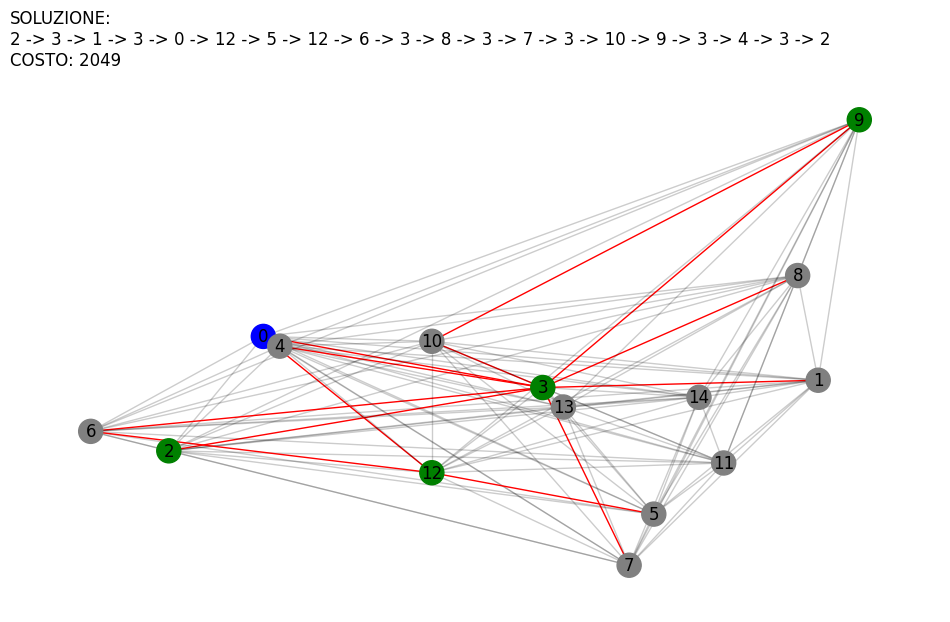

In [13]:
import ant_colony
import networkx as nx
import utility_function as uf

graph_file = "istances/graph.gml"
batteria_max = 150

G = nx.read_gml(graph_file, destringizer=int)
#estraggo i clienti
clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente" or G.nodes[node]['type'] == "deposito"]
print(clienti)

#crea dizionario dei clienti 
client_dict = [G.nodes[i]['pos'] for i in clienti]
for i in clienti:
    tupla = [ int(G.nodes[i]['pos'][1]), int(G.nodes[i]['pos'][0]) ]
    tupla = tuple(tupla)
   



clienti = list(sorted(client_dict))
print(clienti)
print(len(clienti))

results = tsp(clienti)

print("RES", results)

#estraggo la soluzione
soluzione = results[1]

batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione,batteria_per_nodo, batteria_max)

costo = uf.costo(G, soluzione, batteria_per_nodo)
print(soluzione)
print(batteria_per_nodo)
uf.draw_solution(G, soluzione, costo)
